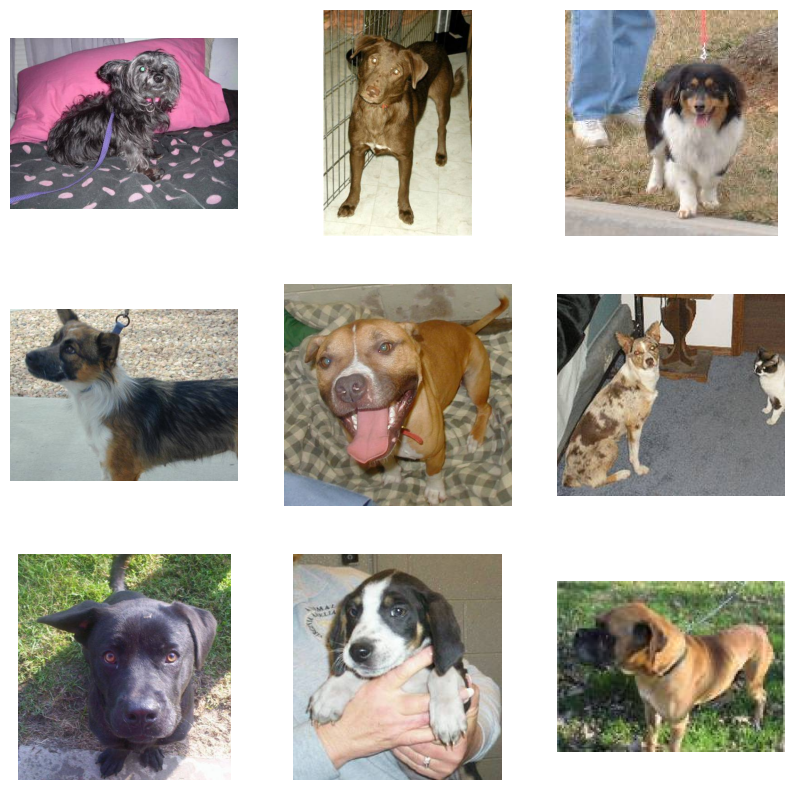

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image

# Display 9 images of dogs
folder = "train/dog"
 
dogs = [x for x in os.listdir(folder) if x.startswith("dog.")]
dogs.sort(key=lambda x: int(x.split(".")[1]))
dogs = dogs[:9]

plt.figure(figsize=(10, 10))
for i, fname in enumerate(dogs, 1):
    img = image.load_img(os.path.join(folder, fname))
    plt.subplot(3, 3, i)
    plt.imshow(image.img_to_array(img) / 255.0)
    plt.axis("off")



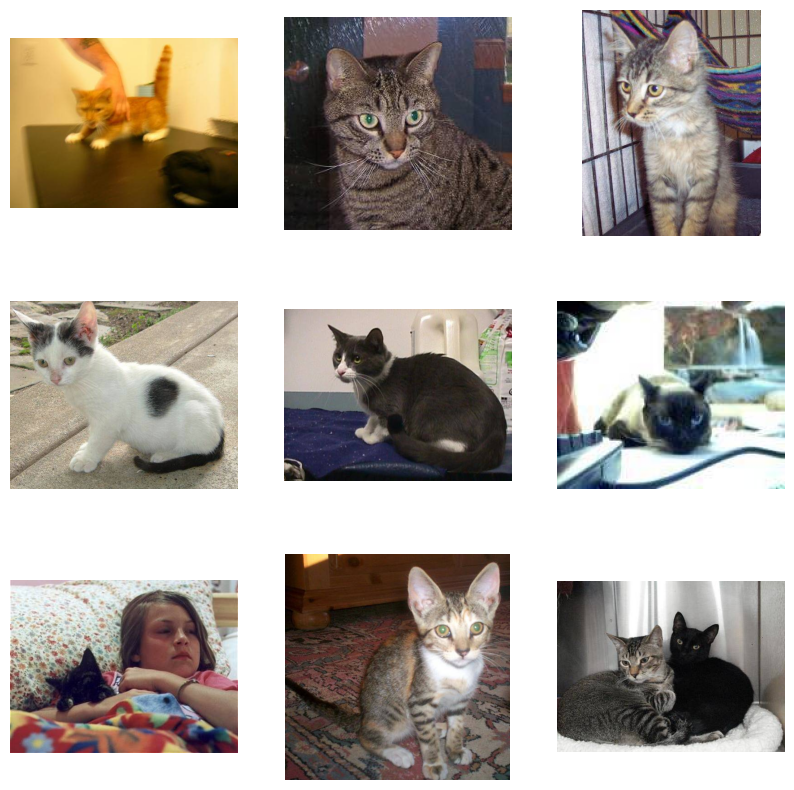

In [ ]:
# Display 9 images of cats

folder = "train/cat"
cats = [x for x in os.listdir(folder) if x.startswith("cat.")]
cats.sort(key=lambda x: int(x.split(".")[1]))
cats = cats[:9]

plt.figure(figsize=(10, 10))
for i, fname in enumerate(cats, 1):
    img = image.load_img(os.path.join(folder, fname))
    plt.subplot(3, 3, i)
    plt.imshow(image.img_to_array(img) / 255.0)
    plt.axis("off")

In [46]:
# Creating a subset of the data as the number of images is burning a hole in my cpu

import os, random, shutil
from pathlib import Path

random.seed(42)

SRC_ROOT = Path(".")          
DST_ROOT = Path("subset")     


N_TRAIN_PER_CLASS = 2000
N_TEST_PER_CLASS  = 500

classes = ["cat", "dog"]

def copy_subset(src_dir, dst_dir, n):
    dst_dir.mkdir(parents=True, exist_ok=True)
    files = [f for f in src_dir.iterdir() if f.is_file() and f.suffix.lower() in [".jpg", ".jpeg", ".png"]]
    random.shuffle(files)
    for f in files[:n]:
        shutil.copy2(f, dst_dir / f.name)

for split, n in [("train", N_TRAIN_PER_CLASS), ("test", N_TEST_PER_CLASS)]:
    for cls in classes:
        src = SRC_ROOT / split / cls
        dst = DST_ROOT / split / cls
        copy_subset(src, dst, n)


In [ ]:
# Setting train and test data pipeline


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "subset/train"
test_dir = "subset/test"
image_size = (224, 224)

datagentrain = ImageDataGenerator()
datagentest = ImageDataGenerator()

# Train Data Generation
train_data = datagentrain.flow_from_directory(
    train_dir,
    target_size = image_size,
    classes = ["dog", "cat"],
    batch_size = 16, 
    shuffle=True
)

# Test Data Generation
test_data = datagentest.flow_from_directory(
    test_dir,
    target_size = image_size,
    classes = ["dog", "cat"],
    batch_size = 16,
    shuffle = False
)


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Adding checkpoint and early stop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Creating CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

cnn = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation="relu"),
    Dense(2, activation="softmax")  
])

cnn.compile(optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"])

# Using fit instead of fit_generator

history = cnn.fit(
    train_data,
    validation_data=test_data,
    epochs=30,   
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30


c:\Users\Yench\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5362 - loss: 284.0941
Epoch 1: val_accuracy improved from None to 0.58000, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.5533 - loss: 69.9571 - val_accuracy: 0.5800 - val_loss: 0.6762
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7500 - loss: 0.5207
Epoch 2: val_accuracy improved from 0.58000 to 0.62700, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.7515 - loss: 0.5094 - val_accuracy: 0.6270 - val_loss: 0.7104
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8869 - loss: 0.3218
Epoch 3: val_accuracy improved from 0.62700 to 0.63500, saving model to best_model.keras

Epoch 3: finished saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.8770 - loss: 0.3142 - val_

In [ ]:
# loads best model
best_model = tf.keras.models.load_model("best_model.keras")

In [ ]:
# Checking loss and accuracy
loss, accuracy = best_model.evaluate(test_data)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6350 - loss: 0.8298
Test Loss: 0.8298302292823792
Test Accuracy: 0.6349999904632568


In [43]:
# Making predictions
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

pred = best_model.predict(test_data)
pred


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


array([[0.69883597, 0.3011641 ],
       [0.9905303 , 0.00946971],
       [0.99898225, 0.00101774],
       ...,
       [0.54665875, 0.45334122],
       [0.02394075, 0.9760592 ],
       [0.5411136 , 0.45888644]], shape=(1000, 2), dtype=float32)

In [ ]:
# Checking overall accuracy

predicted_classes = np.argmax(pred, axis=1)
true_classes = test_data.classes

print(confusion_matrix(true_classes, predicted_classes))
print(classification_report(true_classes, predicted_classes))

# Model is better at predicting dogs than cats. Better at identifying most dogs but misidentifies a lot of cats as dogs. Reasonable for a significantly smaller dataset.

[[374 126]
 [239 261]]
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       500
           1       0.67      0.52      0.59       500

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.63      1000
weighted avg       0.64      0.64      0.63      1000

